In [ ]:
import gibbs_mcmc_nn as mc #imports the file with all the functions of the Gibbs sampler
import torch
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Introduction
In this notebook we will see how to sample form the posterior of a simple, one hidden layer neural network, using the Gibbs sampler.

The algorithm is described in detail in the paper **Gibbs Sampling the Posterior of Neural Networks**.


## Architecture

Let's start by defining the neural network's architecture and the posterior that we wish to sample. We will focus on a neural net with input dimension $d^{(1)}=50$, $d^{(2)}=10$ hidden units and a scalar output. We use ReLU activations. The neural network function is $f(\cdot,W):\mathbb R^d\mapsto \mathbb R$,
\begin{equation}
f(x,W)=b^{(2)}+\sum_{\alpha=1}^{d_2}W^{(2)}_\alpha \sigma\left(W^{(1)T}_\alpha x+b^{(1)}_\alpha\right)
\end{equation}
with the weight matrices $W^{(1)}\in\mathbb R^{d_2 \times d_1}$, $W^{(2)}\in\mathbb R^{1 \times d_2}$, $b^{(1)}\in\mathbb R^{d_2}$, $b^{(2)}\in\mathbb R$. The input vector $x$ lives in $\mathbb R^{d_1}$ and $\sigma(x)=\max(0,x)$.



In [ ]:
def MLP_1_hidden_layer(sigma,W_1,b_1,W_2,b_2,X):
    return (sigma(X@W_1.T+b_1))@(W_2.T)+b_2[None,:]

## Posterior
Let $X\in\mathbb R^{n\times d_1}$ be our training inputs and $y\in\mathbb R^n$ the training labels. $n$ is the size of the training set.

We want to sample from the posterior
\begin{equation}
P(W|X,y)=\frac{P(y|X,W)P(W)}{P(y|X)},
\end{equation}
where $W$ indicates all the parameters of the network.
Given an architecture $f$ there are several ways to translate it into a posterior. The Gibbs sampler allows to sample one of these forms, named the intermediate noise posterior.
Define $Z^{(2)}\in\mathbb R^{n\times d_2}, X^{(2)}\in\mathbb R^{n\times d_2}$ to respectively the pre- and post- activations of the first layer.
We will draw samples from the probability.
\begin{align}
&P(W,Z^{(2)},X^{(2)}|X,y)=\\&=\frac{1}{\mathcal Z}\exp\left\{-\frac{1}{2\Delta}\sum_{\mu=1}^n(y^\mu-b^{(2)}-W^{(2)T}X^{(2)\mu})^2-\frac{1}{2\Delta}\left[\sum_{\mu=1}^{n}\sum_{\alpha=1}^{d_2}\left(X^{(2)\mu}_\alpha-\sigma(Z^{(2)\mu}_\alpha)\right)^2+\left(Z^{(2)\mu}_\alpha-b^{(1)}_\alpha-W_\alpha^{(1)T}X^\mu\right)^2\right]\right\}\times\\&\times\exp\left[-\frac{\lambda_W^{(1)}}{2}\sum_{\alpha=1}^{d_2}\sum_{i=1}^{d_1}(W^{(1)}_{\alpha i})^2-\frac{\lambda_b^{(1)}}{2}\sum_{\alpha=1}^{d_2}(b^{(1)}_{\alpha})^2-\frac{\lambda_W^{(2)}}{2}\sum_{\alpha=1}^{d_2}(W^{(2)}_{\alpha})^2-\frac{\lambda_b^{(2)}}{2} (b^{(2)})^2\right]
\end{align}

$\Delta$ is a *temperature* parameter for the Gibbs sampler.
We place a i.i.d. gaussian prior on each weight vector. $\lambda_W^{(1)},\lambda_b^{(1)},\lambda_W^{(2)},\lambda_b^{(2)}$ are the inverse variances of the prior of respectively the first layer weights and biases and second layer weights and bias.


The Gibbs sampler draws samples from this posterior by iteratively sampling each of $W^{(1)},b^{(1)},Z^{(2)},X^{(2)},W^{(2)},b^{(2)}$ from its conditional distribution on all other variables.





## Dataset generation

In the following cell we generate a synthetic training set with $n=2084, d^{(1)}=50$. `X_train`,`y_train` will denote respectively the training inputs and labels.`X_test`,`y_test` are instead the test inputs and labels. The training labels are generated introducing a Gaussian noise with variance `Delta_teach` in $Z^{(2)},X^{(2)}, y$. Instead the test labels are generated in a noiseless way.

The inputs are taken to be i.i.d. standard normals, while the labels are generated by a teacher network. The teacher network in turn is sampled form the prior, we pick $\lambda_W^{(1)}=\lambda_W^{(1)}=d_1$, $\lambda_W^{(2)}=\lambda_b^{(2)}=d_2$.

In [ ]:
n=2084
d_1=torch.tensor(50)
d_2=torch.tensor(10)
sigma=torch.nn.ReLU()
lambda_W_1_teach=d_1
lambda_b_1_teach=d_1
lambda_W_2_teach=d_2
lambda_b_2_teach=d_2
Delta_teach=torch.tensor(1e-3)
n_test=2000


X_train=torch.randn(size=[n,d_1])
W_1_teach=torch.randn(size=[d_2,d_1])/torch.sqrt(lambda_W_1_teach)
b_1_teach=torch.randn(size=[d_2])/torch.sqrt(lambda_b_1_teach)
W_2_teach=torch.randn(size=[1,d_2])/torch.sqrt(lambda_W_2_teach)
b_2_teach=torch.randn(size=[1])/torch.sqrt(lambda_b_2_teach)

Z_2_teach=X_train@(W_1_teach.T)+b_1_teach[None,:]+torch.sqrt(Delta_teach)*torch.randn(size=[n,d_2])
X_2_teach=sigma(Z_2_teach)+torch.sqrt(Delta_teach)*torch.randn(size=[n,d_2])
y_train=b_2_teach[None,:]+X_2_teach@(W_2_teach.T)+torch.sqrt(Delta_teach)*torch.randn(size=[n,1])
y_train_noiseless=MLP_1_hidden_layer(sigma,W_1_teach,b_1_teach,W_2_teach,b_2_teach,X_train)

#generate test set
X_test=torch.randn(size=[n_test,d_1])
y_test=MLP_1_hidden_layer(sigma,W_1_teach,b_1_teach,W_2_teach,b_2_teach,X_test)

## Gibbs parameters

We will now run the Gibbs sampler on the dataset. 
First we must set the algorithm's parameters, i.e., $\Delta,\lambda_W^{(1)},\lambda_W^{(1)},\lambda_W^{(2)}, \lambda_b^{(2)}$. Since we want to carry out Bayes optimal inference we set them to the same value as the teacher.

In [ ]:
sigma_=torch.nn.ReLU()
lambda_W_1=d_1
lambda_b_1=d_1
lambda_W_2=d_2
lambda_b_2=d_2
Delta=torch.tensor(1e-3)

## Initialization
for the Gibbs sampler we set all variables initially to zero. This correponds to an uninformed initialization, in the sense that the network is initialized independently of the teacher network that generated the dataset.
As an alternative one can initialize all variables on the teacher network's counterparts. We refer to this as an "informed" initialization.


In [ ]:
#zero initialization
W_1=torch.zeros(size=[d_2,d_1])
b_1=torch.zeros(size=[d_2])
Z_2=torch.zeros(size=[n,d_2])
X_2=torch.zeros(size=[n,d_2])
W_2=torch.zeros(size=[1,d_2])
b_2=torch.zeros(size=[1])


"""
#informed initialization
W_1=W_1_teach.clone()
b_1=b_1_teach.clone()
Z_2=Z_2_teach.clone()
X_2=X_2_teach.clone()
W_2=W_2_teach.clone()
b_2=b_2_teach.clone()
"""

'\n#informed initialization\nW_1=W_1_teach.clone()\nb_1=b_1_teach.clone()\nZ_2=Z_2_teach.clone()\nX_2=X_2_teach.clone()\nW_2=W_2_teach.clone()\nb_2=b_2_teach.clone()\n'

In [ ]:
#moving the variables to the GPU (if needed)
Delta=Delta.to(device)
lambda_W_1=lambda_W_1.to(device)
lambda_b_1=lambda_b_1.to(device)
lambda_W_2=lambda_W_2.to(device)
lambda_b_2=lambda_b_2.to(device)
W_1=W_1.to(device)
b_1=b_1.to(device)
Z_2=Z_2.to(device)
X_2=X_2.to(device)
W_2=W_2.to(device)
b_2=b_2.to(device)
X_train=X_train.to(device)
y_train=y_train.to(device)
y_train_noiseless=y_train_noiseless.to(device)
X_test=X_test.to(device)
y_test=y_test.to(device)
if(str(device)=='cuda'): 
    torch.set_default_tensor_type(torch.cuda.FloatTensor) #this is necessary so that tensors generated during the algorithm are allocated on the GPU

In [ ]:
#stuff to track during the dynamics
test_loss=[]
train_loss=[]
W_1_norm=[]
W_2_norm=[]
tmax=5000

In [ ]:
#should take about 1 minute to run
for t in range(tmax):
    y_pred_test=MLP_1_hidden_layer(sigma,W_1,b_1,W_2,b_2,X_test)
    y_pred_train=MLP_1_hidden_layer(sigma,W_1,b_1,W_2,b_2,X_train)
    test_loss.append(torch.mean((y_pred_test-y_test)**2).item())
    train_loss.append(torch.mean((y_pred_train-y_train_noiseless)**2).item())

    #updating the variables (in this case in reverse order)
    W_2=mc.sample_W_l_fcl(X_2,b_2,y_train,lambda_W_2,Delta)
    b_2=mc.sample_b_l_fcl(W_2,y_train,X_2,Delta,lambda_b_2)
    X_2=mc.sample_X_l_fcl(sigma(Z_2),W_2,b_2,y_train,Delta,Delta) 
    Z_2=mc.sample_Z_lp1_relu(X_train@(W_1.T)+b_1[None,:],X_2,Delta,Delta)
    W_1=mc.sample_W_l_fcl(X_train,b_1,Z_2,lambda_W_1,Delta)
    b_1=mc.sample_b_l_fcl(W_1,Z_2,X_train,Delta,lambda_b_1)

(1e-05, 1)

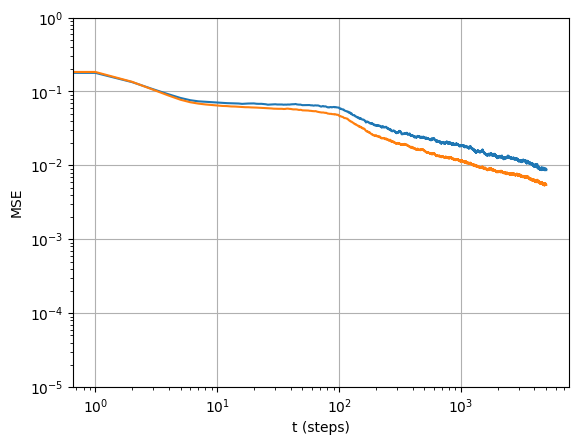

In [ ]:
plt.plot(test_loss,label="test MSE")
plt.plot(train_loss,label="train MSE")
plt.xlabel("t (steps)")
plt.ylabel("MSE")
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.ylim([1e-5,1])

## Faster implementation

The sampling of the first layer's weights can be sped up by precomputing the covarinace (and its cholesky decomposition) of the first layer's weights and biases. Also exploiting a simplification when sampling $X^{(2)}$ for the case when the output has only one neuron.
The larger the input dimension $d_1$ the more significant the speedup.

In [ ]:
#initializing all variables to zero
W_1=torch.zeros(size=[d_2,d_1])
b_1=torch.zeros(size=[d_2])
Z_2=torch.zeros(size=[n,d_2])
X_2=torch.zeros(size=[n,d_2])
W_2=torch.zeros(size=[1,d_2])
b_2=torch.zeros(size=[1])
"""
#informed initialization
W_1=W_1_teach.clone()
b_1=b_1_teach.clone()
Z_2=Z_2_teach.clone()
X_2=X_2_teach.clone()
W_2=W_2_teach.clone()
b_2=b_2_teach.clone()
"""
#moving the variables to the GPU (if needed)
Delta=Delta.to(device)
lambda_W_1=lambda_W_1.to(device)
lambda_b_1=lambda_b_1.to(device)
lambda_W_2=lambda_W_2.to(device)
lambda_b_2=lambda_b_2.to(device)
W_1=W_1.to(device)
b_1=b_1.to(device)
Z_2=Z_2.to(device)
X_2=X_2.to(device)
W_2=W_2.to(device)
b_2=b_2.to(device)
X_train=X_train.to(device)
y_train=y_train.to(device)
y_train_noiseless=y_train_noiseless.to(device)
X_test=X_test.to(device)
y_test=y_test.to(device)
if(str(device)=='cuda'): 
    torch.set_default_tensor_type(torch.cuda.FloatTensor) #this is necessary so that tensors generated during the algorithm are allocated on the GPU

#precomputing quantities to sample the first layer's weights and biases faster
sum_X=torch.sum(X_train,axis=0)[None,:]
up_block=torch.cat((torch.tensor([[lambda_b_1*Delta+n]]),sum_X),axis=1)
down_block=torch.cat((sum_X.T,(X_train.T)@X_train+Delta*lambda_W_1*torch.eye(d_1)),axis=1)
Cov_W_b_resc=torch.linalg.inv(torch.cat((up_block,down_block),axis=0))
Cholesky_Cov_W_b_resc=torch.linalg.cholesky(Cov_W_b_resc) 
Cov_W_b_resc_XT = Cov_W_b_resc @ torch.cat((torch.ones([n,1]),X_train),axis=1).T 

In [ ]:
test_loss=[]
train_loss=[]
tmax=5000

In [ ]:
#should take about 1 minute to run
for t in range(tmax):
    y_pred_test=MLP_1_hidden_layer(sigma,W_1,b_1,W_2,b_2,X_test)
    y_pred_train=MLP_1_hidden_layer(sigma,W_1,b_1,W_2,b_2,X_train)
    test_loss.append(torch.mean((y_pred_test-y_test)**2).item())
    train_loss.append(torch.mean((y_pred_train-y_train_noiseless)**2).item())

    #updating the variables (in this case in reverse order)
    W_2=mc.sample_W_l_fcl(X_2,b_2,y_train,lambda_W_2,Delta)
    b_2=mc.sample_b_l_fcl(W_2,y_train,X_2,Delta,lambda_b_2)
    X_2=mc.sample_X_L_fcl(sigma(Z_2),W_2,b_2,y_train,Delta,Delta)
    Z_2=mc.sample_Z_lp1_relu(X_train@(W_1.T)+b_1[None,:],X_2,Delta,Delta)
    W_1,b_1=mc.sample_W_b_1_fcl(Cholesky_Cov_W_b_resc,Cov_W_b_resc_XT,Z_2,Delta)

(1e-05, 1)

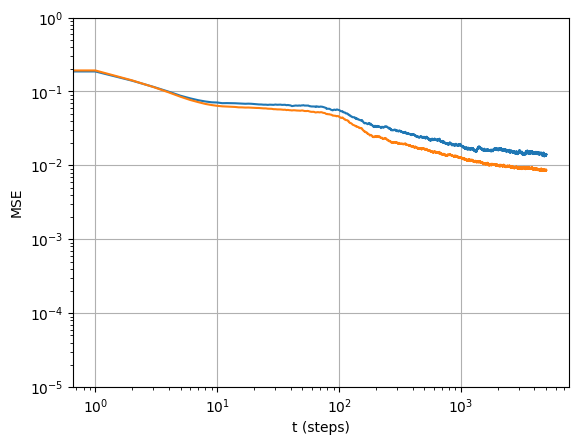

In [ ]:
plt.plot(test_loss,label="test MSE")
plt.plot(train_loss,label="train MSE")
plt.xlabel("t (steps)")
plt.ylabel("MSE")
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.ylim([1e-5,1])